In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

This notebook processes the data for seasonal batting averages to be used in the pitch outcome modelling. The numbers of dimensions is reduced using Principal component analysis. Batter and pitcher data is processed seperately (pitching is detailed in a separate notebook). The outputs of the notebook are used in the modelling notebook. 

### Seasonal batting data 

alongside the pitch-by-pitch data, seasonal batting data is downloaded directly via Baseballsavant.com via thier custom leaderboard (https://baseballsavant.mlb.com/leaderboard/statcast) 

This data is used for Principal component analysis to reduce the numbers of variables into indentifiable hitter dimensions. The variables downloaded from statcast are:


1. 'last_name, first_name' - last and first name of the pitcher
2. 'player_id' - player id as defined by MLB
3. 'year' - baseball season
4. 'pa' - number of plate appearances 
5. 'k_percent' - stike out percentage
6. 'bb_percent' - walk percentange
7. 'xba' - expected batting average
8. 'xslg' - expected slugging
9. 'xwoba' - expected Weighted On-base Average
10. 'xwobacon' - expected weighted On-Base Average on Contact

12. 'hard_hit_percent' - the percentage of batted balls with an exit velocity of 95 mph or more.
13. 'sweet_spot_percent' - The percentange of batted-balls with a launch angle between eight and 32 degrees.
14. 'avg_hyper_speed' - average exit velocity
15. 'z_swing_percent' - percentage of in-zone swings
16. 'z_swing_miss_percent' - percentage of in-zone swings and misses
17. 'iz_contact_percent' - percentage of in-zone contact
18. 'oz_swing_percent' - percentage of out-of-the-zone swings
19. 'oz_swing_miss_percent' - percentage of out-of-the-zone swings and misses
20. 'oz_contact_percent' - percentage of out-of-the-zone contact
21.  The following variables are derived by statcast as a combination of launch angle and exit velocity. For more information please see MLB's description: https://www.mlb.com/glossary/statcast/sweet-spot

- 'barrel_batted_rate' -the percentage of batted balls with the perfect combination of exit velocity and launch angle

- 'poorlyweak_percent' - percentage of balls hit with weak contact

- 'poorlyunder_percent' -percentage of balls hit under

- 'poorlytopped_percent' -percentage of balls topped

- 'solidcontact_percent' - percentage of balls hit with solid contact

- 'flareburner_percent', - percentage of flare/burners hit


21. 'xhr' - expected home runs (this was downloaded separaterly and merged together)

## merging and cleaning 

Before conducting PCA the data set needs to be cleaned by removing people with a low number of plate appearances in the season (as their average statistics may not necessarily be representative of a typical season. 

In [8]:
df_sc = pd.read_csv("batterstats24_statcast.csv")  #
hr = pd.read_csv("homeruns_24.csv") #home runs data also from statcast but needed to download separately and merge

In [9]:
#merging home runs into main dataset
df_sc = df_sc.rename(columns={"last_name, first_name": "Name"})  #matching name variables to merge together 
hr = hr.rename(columns={"player": "Name"})

hr = hr[["Name","team_abbrev", "xhr"]]


In [10]:
df_sc = pd.merge(df_sc, hr, how='left', on=['Name'])

In [11]:
df_sc.loc[df_sc.xhr.isna(), 'xhr'] = 0 #for players that had no homeruns this will appear as NA therefore converting to 0 

In [12]:
#creating xhr rate per plate appearance variable 
df_sc["xhr_rate"] = df_sc.xhr / df_sc.pa

In [13]:
#removing people with less than 50 plate appearances
df_sc = df_sc[df_sc.pa > 50]


In [14]:
df_sc.reset_index(drop=True, inplace=True)  # Reset index 

In [15]:
df_sc.columns

Index(['Name', 'player_id', 'year', 'pa', 'k_percent', 'bb_percent', 'xba',
       'xslg', 'xwoba', 'xwobacon', 'sweet_spot_percent', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'avg_hyper_speed', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent', 'oz_contact_percent',
       'iz_contact_percent', 'team_abbrev', 'xhr', 'xhr_rate'],
      dtype='object')

### Principal component analysis (PCA)

Many of the metrics used in baseball are all highly correlated. A batter with a high expected home run rate (xhr_rate) is typically going to have a high expected slugging rate (xslg). We can observe this by conducting pairwise correlations of all the variables (plots have been split out by type of metrics: power, plate discipline and contact quality)



In [16]:
#select variables for PCA (dropping name id etc.)
data = df_sc[['k_percent', 'bb_percent', 'xba',
       'xslg', 'xwoba', 'xwobacon', 'sweet_spot_percent', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'avg_hyper_speed', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent', 'xhr_rate']]

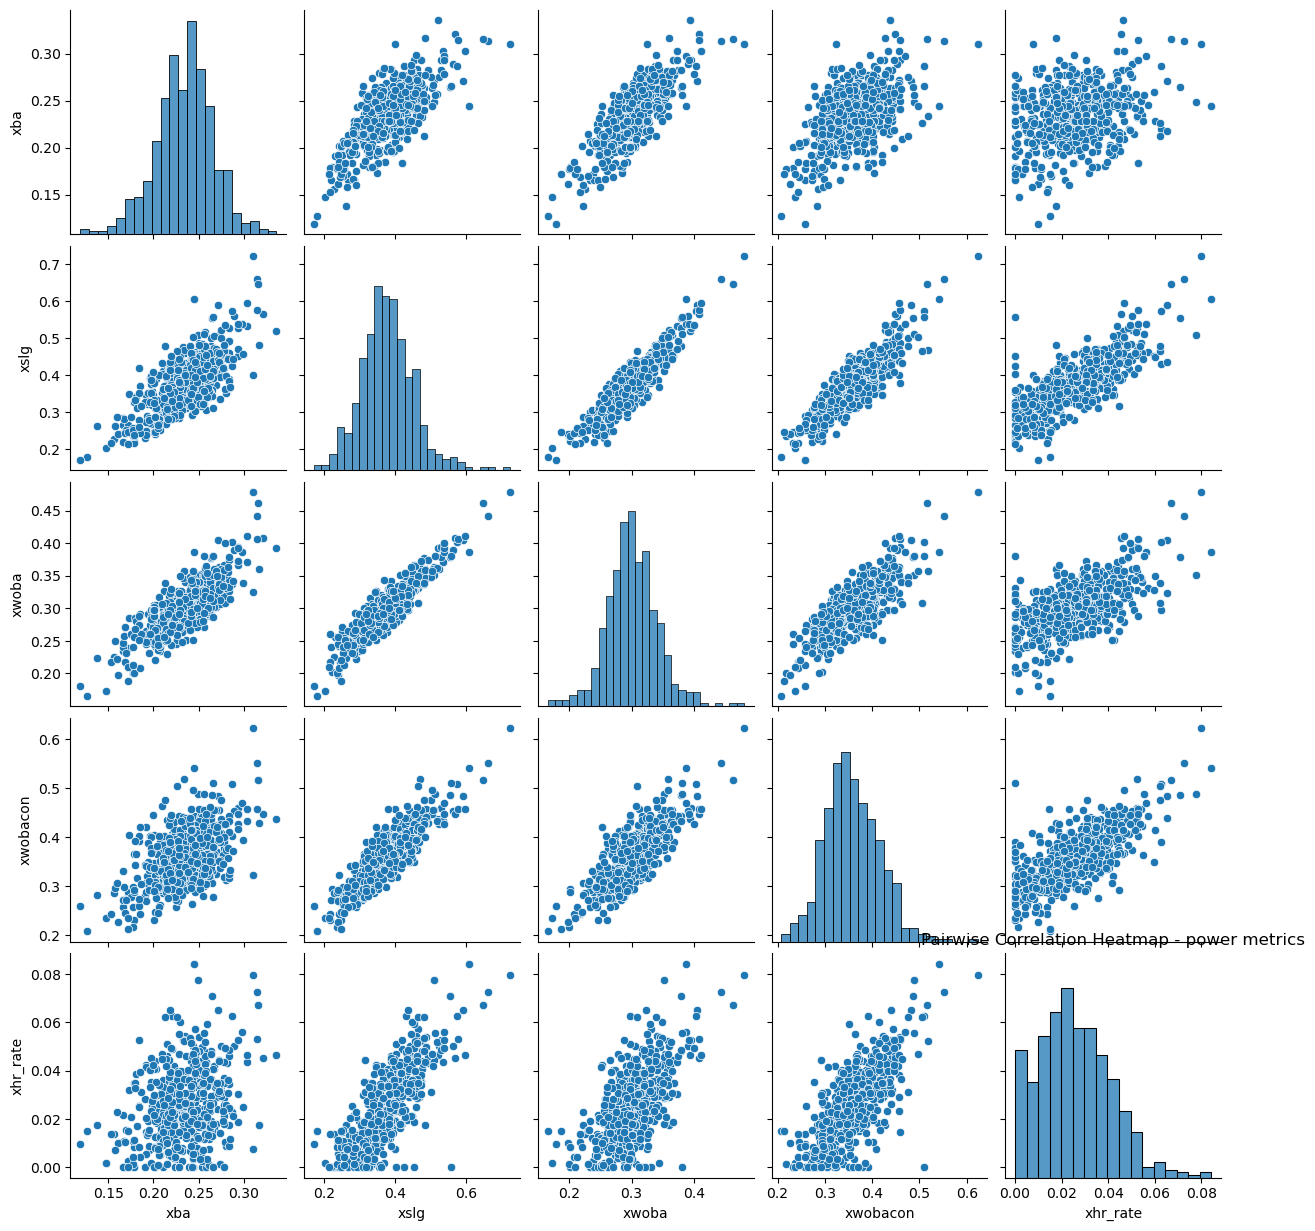

In [17]:
import warnings

# Suppress warnings only for this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.pairplot(data[[ 'xba','xslg', 'xwoba', 'xwobacon',  'xhr_rate']])
    plt.title("Pairwise Correlation Heatmap - power metrics")
    plt.show()

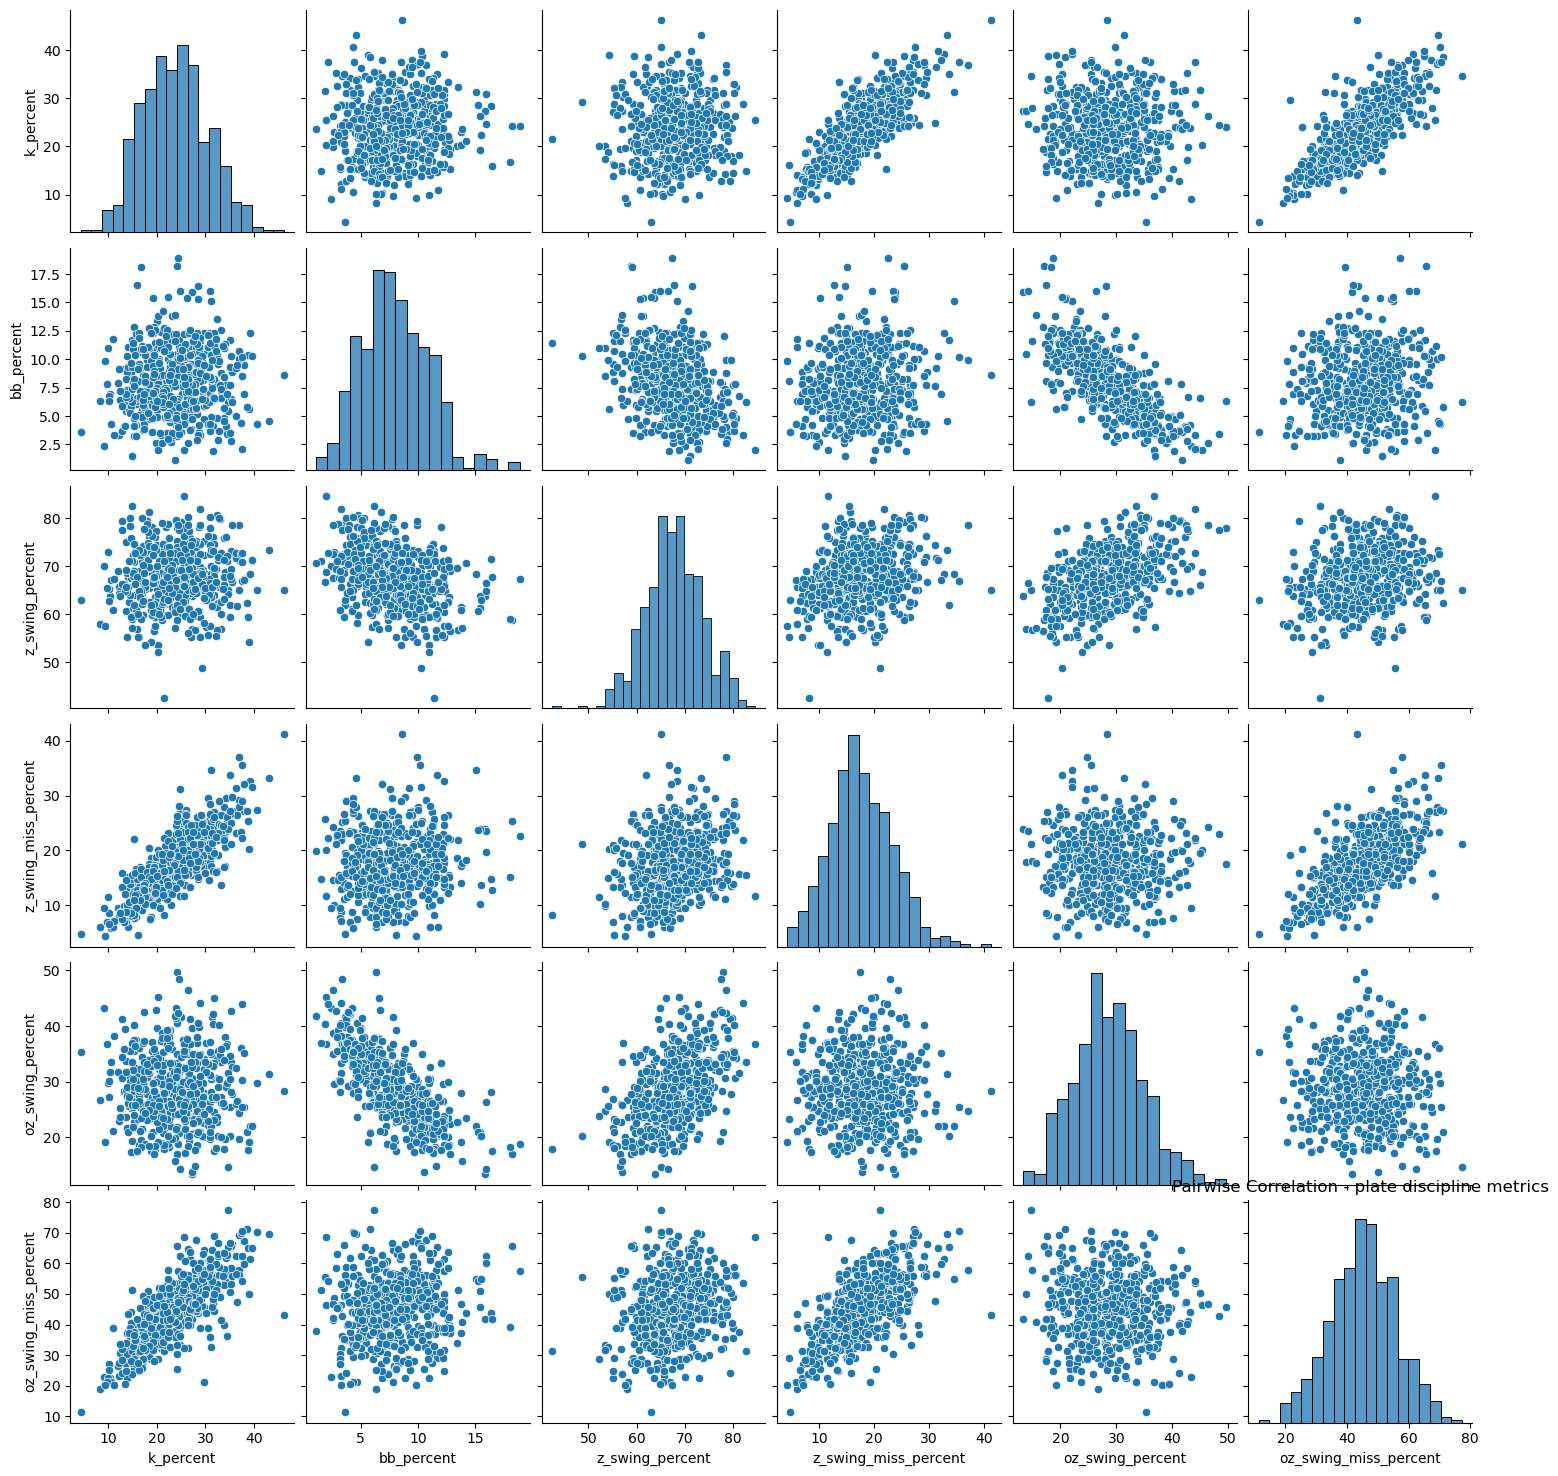

In [18]:


# Suppress warnings 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.pairplot(data[['k_percent', 'bb_percent', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent']])
    plt.title("Pairwise Correlation - plate discipline metrics")
    plt.show()

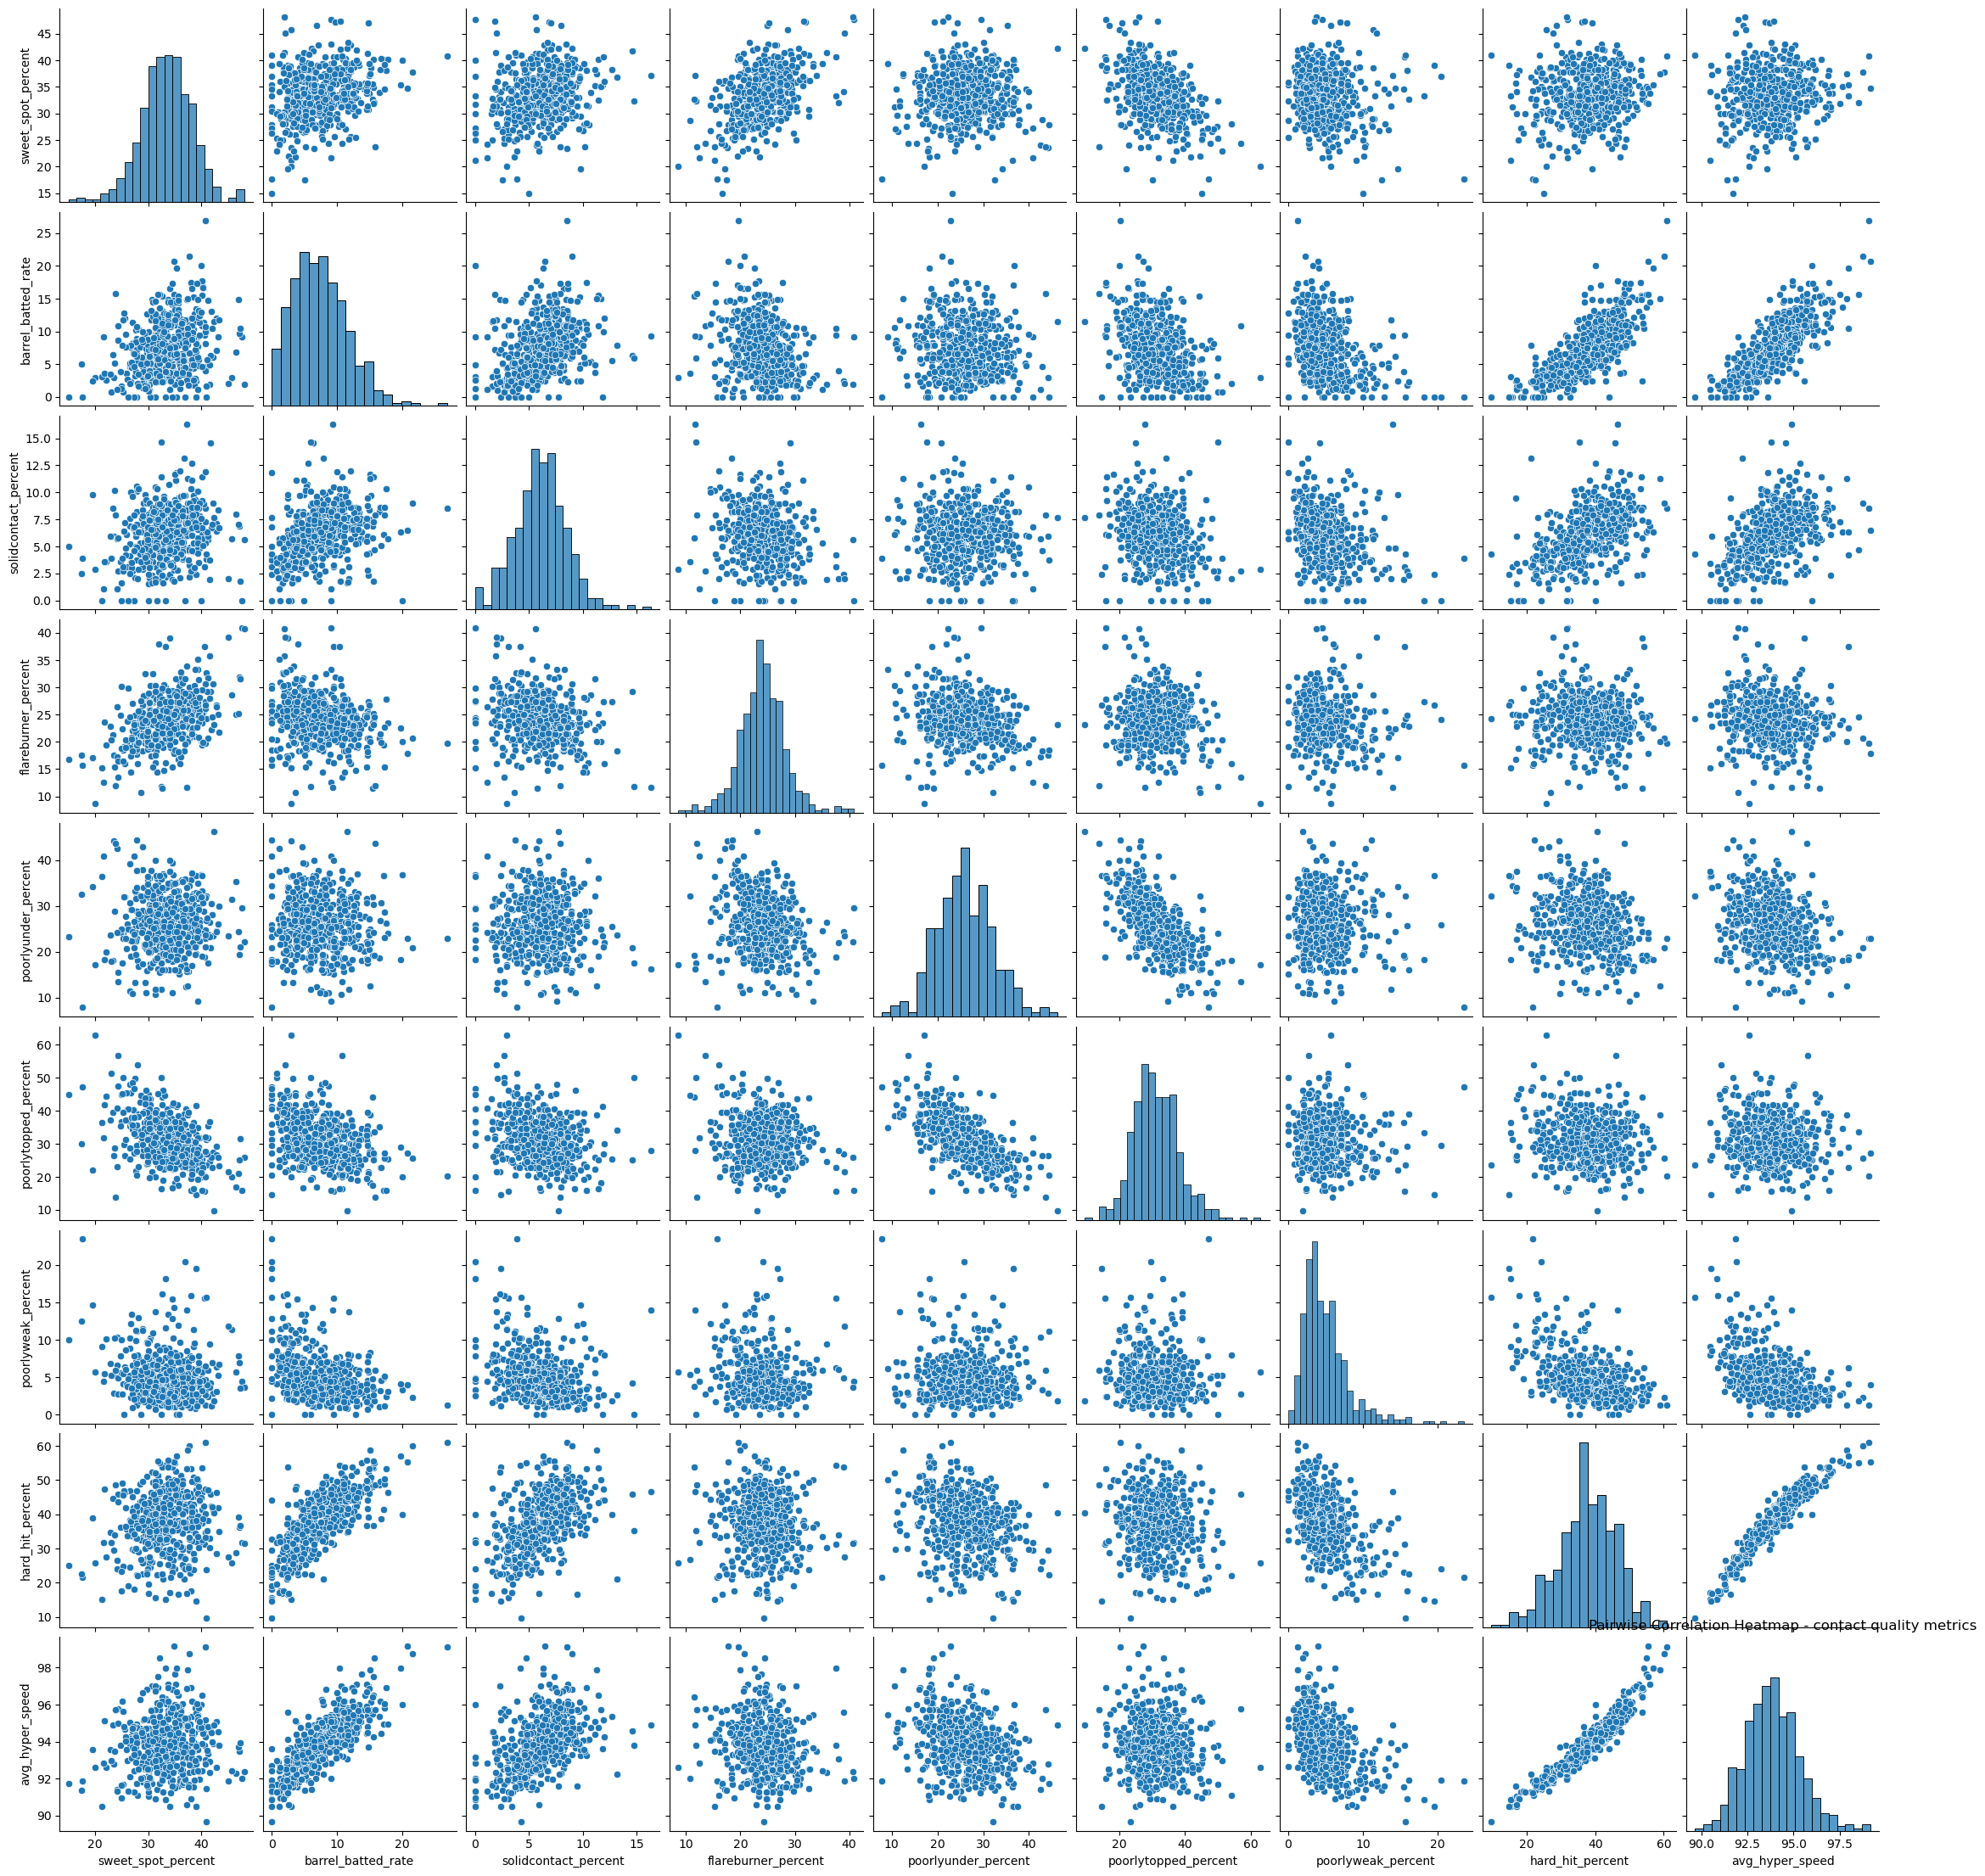

In [19]:


# Suppress warnings only 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.pairplot(data[['sweet_spot_percent', 'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
           'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
           'avg_hyper_speed']])
    plt.title("Pairwise Correlation Heatmap - contact quality metrics")
    plt.show()


As we can see from the plots, there is a lot of correlation in the data. Whilst some models are able to handle this, it can be beneficial to reduce the number of dimensions using principal component analysis (PCA). 

PCA is a dimension reduction technique which is used to reduce a high number of correlated variables into a smaller set of uncorrelated variables (principal components (PCs)). PCA preserves the most important patterns or relationships between those variables. The principal components then represent underlying dimensions present in the data.

PCA is an unsupervised technique and the number of PCs need to be manually set. To determine this we can plot the PCs against the cumulative variance of the data. The first principal component captures the most variance, and susequent PCs capture progressively less. There are a number of methods used to choose the number of PCs including the elbow method (the point at which the plotted variance begins to tail off), or aprior decisions to take PCs that contribute a certain proportion of variance. 

Prior to conducting PCA, the data is scaled to ensure that all variables are comparable to one another

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [21]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
#data_test_scaled = scaler.transform(data_test)


Component 1 
Fraction of total variance explained by this variable: 0.3423817877874273 
 Total fraction of variance explained by the first 1 variable(s): 0.3423817877874273

Component 2 
Fraction of total variance explained by this variable: 0.17515996889178417 
 Total fraction of variance explained by the first 2 variable(s): 0.5175417566792114

Component 3 
Fraction of total variance explained by this variable: 0.10933096047242881 
 Total fraction of variance explained by the first 3 variable(s): 0.6268727171516403

Component 4 
Fraction of total variance explained by this variable: 0.0945568293051321 
 Total fraction of variance explained by the first 4 variable(s): 0.7214295464567724

Component 5 
Fraction of total variance explained by this variable: 0.07816007040046749 
 Total fraction of variance explained by the first 5 variable(s): 0.7995896168572398

Component 6 
Fraction of total variance explained by this variable: 0.045511689485548464 
 Total fraction of variance explaine

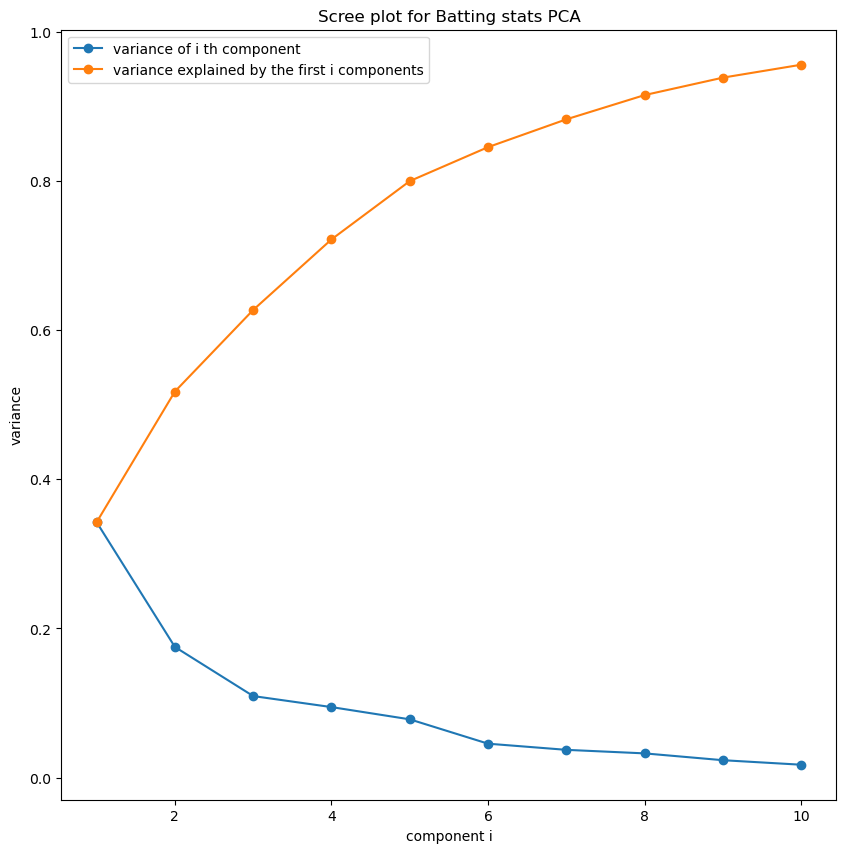

In [22]:
pca = PCA(10).fit(data_scaled)
var = pca.explained_variance_ratio_
var_explained = np.zeros(10)
for i in range(10):
    var_explained[i] = sum(var[:i+1])

for i in range(10):
    print("\nComponent", i+1 , "\nFraction of total variance explained by this variable:", var[i],
            "\n Total fraction of variance explained by the first %s variable(s):" % (i +1), var_explained[i] )

plt.figure(figsize = (10,10))
plt.plot(range(1, len(var_explained)+1), var, label = "variance of i th component", marker = "o")
plt.plot(range(1, len(var_explained)+1), var_explained, label = "variance explained by the first i components", marker = "o")
plt.xlabel("component i")
plt.ylabel("variance")
plt.title("Scree plot for Batting stats PCA")
plt.legend()
plt.show()


Based on the plot and the variance explain, I have opted for 5 PCs as the variance explained by each component was at least 5%. In total the chosen PCs explain 79.9% of the variance. Since the aim is to use these PCs in further modelling we do not want to throw away too much variance that could be valuable. 

In [23]:

pca = PCA(5).fit(data_scaled)
# Create a DataFrame of the PCA components
loadings = pd.DataFrame(pca.components_.T, index=data.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
#loadings.to_clipboard(index=True)

We can the evaluate the PCs using a number of approaches. A heat map can show generally how the variables load on to each PC. (each PCs is sorted iteratively to make it easier to determine which variables load onto each component)

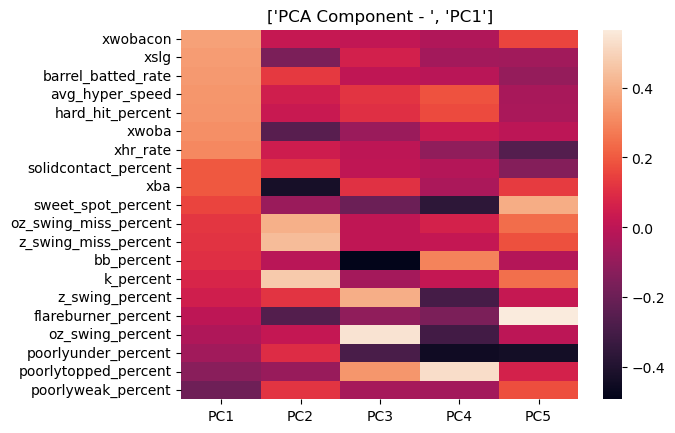

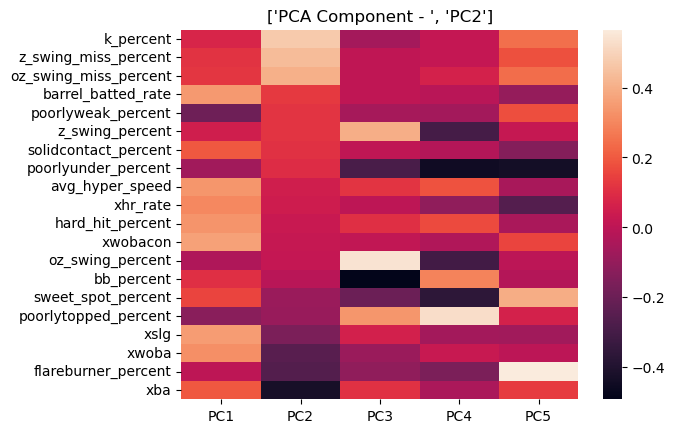

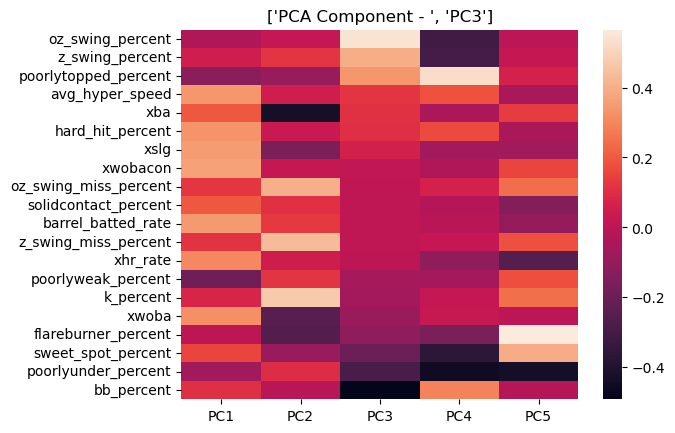

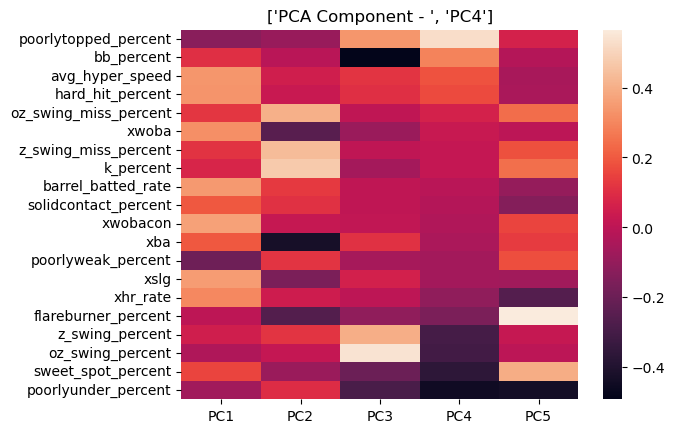

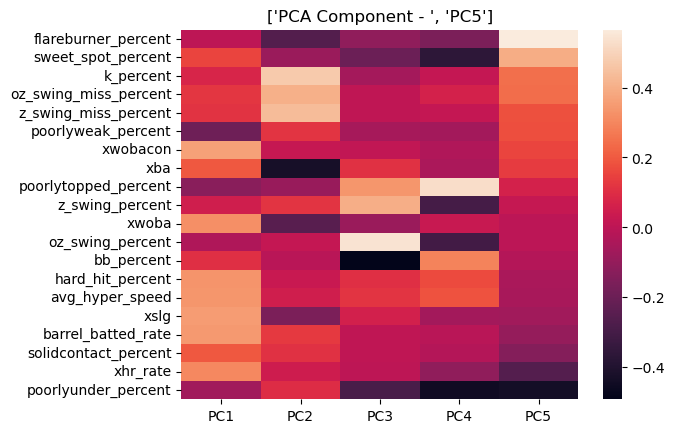

In [24]:
for i in loadings.columns:
    x = loadings.sort_values(by = i, ascending = False)
    sns.heatmap(x)
    plt.title(['PCA Component - ',i])
    plt.show()

From these plots we can interpret the PCs as the following: 

**PC1 - 'Contact quality'**:

The metrics that load onto this PC are those that measure the extent to which the hitter hits for power. Conversely the metrics that load negatively on to this PC are poor/weak hits. 

**PC2 - 'contact frequency'**:

Metrics that load onto this PC are high strike outs, high swing and miss rate and a low batting average, indicating that this PC measures how frequently a batter makes contact with the ball

**PC3 - 'Aggression'**

Metrics that load onto this are high swing rates and a low walk rate (bb_percent), indicating this PC measures how aggressive a player is at the plate.

**PC4** and **PC5** are less interpretable, however the contribute a much smaller amount of variance so they may be capturing a more nuanced combination of metrics. 


The last step is to save the model, add the PCA scores to the data set and save the csv file.

In [25]:
#adding scores into main dataframe

pca_scores = pca.transform(data_scaled) 

# # Create a DataFrame for the principal components
pc_df = pd.DataFrame(pca_scores, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# # Concatenate the original DataFrame with the principal components
df = pd.concat([df_sc, pc_df], axis=1)



In [26]:
import joblib

# Save the PCA model
joblib.dump(pca, "batting_pca_model.pkl")


['batting_pca_model.pkl']

In [27]:
#df.to_csv("batstats24_withPCA.csv") #save dataset with PCA use in the modelling